# 4.4 Logistic Regression and Model Comparison

# Content:
$\rightarrow$ Logistic regression and its implementation.

$\rightarrow$ Multiple logistic Regression.

$\rightarrow$ Multinomial Regression.

$\rightarrow$ Model comparison.

$\rightarrow$ Occam's razor- simplicity and accuracy.

$\rightarrow$ Overfitting and Underfitting.

$\rightarrow$ Regularizing priors.

$\rightarrow$ information criteria.

$\rightarrow$ Bayes factor.

$\rightarrow$ References.

## List of symbols
$\rightarrow \mu $ is varience.

$\rightarrow  p $  is probability.

$\rightarrow r $ is acceptance ratio.

$\rightarrow n_i $ is number of bugs in $i^{th}$ observations.

$\rightarrow y_i $ is number of bugs killed.

$\rightarrow x_i $ is dosage.

$\rightarrow \theta $ is logistic model.

$\rightarrow Bern(\theta) $ is Bernouli distribution of logistic model.

$\rightarrow z $ is logistic function.

In [0]:
%matplotlib inline
import io
from google.colab import files
import numpy as np;
import pandas as pd
from scipy import stats
import pymc3 as pm
from scipy.stats import norm
from scipy.interpolate import griddata
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns;
import time

tfd = tfp.distributions
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

# Introduction:
## Logistic Regression: 
Logistic regression is extension of linear regression. It is a model where Dependent variable is categorical. This lecture we discuss about binary depedent variable where output take only two values "0" or "1" such that outputs of those can be assumed as either pass or fail, sick or healthy, on or off. If the dependent variables have more than two outcomes then this can be analysed as multinomial logistic regression.

## Logistic function:
We can define logistic function by taking of an example of Insecticide. Logistic function is used because if input given from $-\infty$ to $ \infty$ i.e. if we give real values as input then output will takes place between 0 and 1. 
Now, In Insecticide Let $x_i$ be dosage for $i^{th}$ observations, and $n_i$ be Number of bugs that set to be sprayed, and $y_i$ is killed number of bugs.

$ \Rightarrow y_i \approx \beta_{in}{(n_i,h_i)}$

$ \Rightarrow \mu = f(\alpha + \beta x_i)$   ( where $f$ is inverse link function that links linear model to output which cover Range of $ \alpha + \beta x_i$ into [0,1])

#### Logistic model:
$\Rightarrow logistic(z) = \frac {1} {\large{(1+e^{-z})}} $ ( where z is the logistic function)
$\Rightarrow y_i = Bern(\theta_i)  $ 


$ \Rightarrow \theta= logistic (\alpha +\beta x_i)$

In logistic model $\theta$ is defined by linear model. linear model could return any value from the real line, but bernouli distribution expected to be in intreval of [0,1]. So we use inverse link function such that values returned by linear model will be in range suitable to bernouli distribution.

#### Visualize the Logistic model:

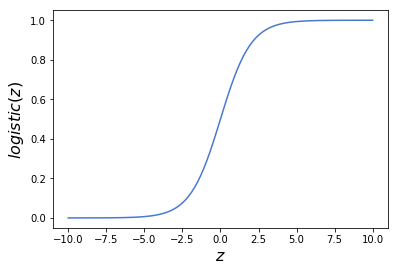

In [0]:
# Build the logistic model:
z = np.linspace(-10, 10, 100)
logistic = 1 / (1 + np.exp(-z))

# Plot the logistic model:
plt.plot(z, logistic)
plt.xlabel('$z$', fontsize=16)
plt.ylabel('$logistic(z)$', fontsize=16)
plt.savefig('B04958_05_01.png', dpi=300, figsize=(5.5, 5.5))

### Implementation of Logistic Regression Model using iris dataset:
Iris data set is a classic data set which contains information about three species of flowers from genus iris (setosa, virginca, versicolor).These are our dependent variables and our four independent variables are petal length, petal width, sepal length and sepal width. where we plot three species versus sepal length  using stripplot function from seaborn:
From below plots we can see that Y-axis is continuos and X-axis is categorical. We use variousnumber of different way to inspect the data: Jitter argument and scatter matrix as shown in the below code. 
in Jitter arument and scatter matrix graphs are taken to sepal length for three species, in scatter matrix the obtained graphs are arranged in $4 \times 4$ matrix. these different species are plotted with different color code as shown in below.

### 1. Read the data

In [0]:
# Read the data
uploaded = files.upload()
iris = pd.read_csv(io.BytesIO(uploaded['iris.csv']), sep=',', header=0)
iris = sns.load_dataset("iris")
iris.head()

Saving iris.csv to iris (8).csv


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


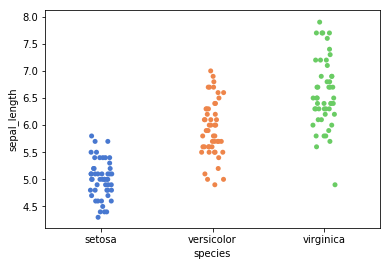

In [0]:
sns.stripplot(x=iris["species"], y=iris["sepal_length"], data=iris, jitter=True)
plt.savefig('B04958_05_03.png', dpi=300, figsize=(5.5, 5.5))

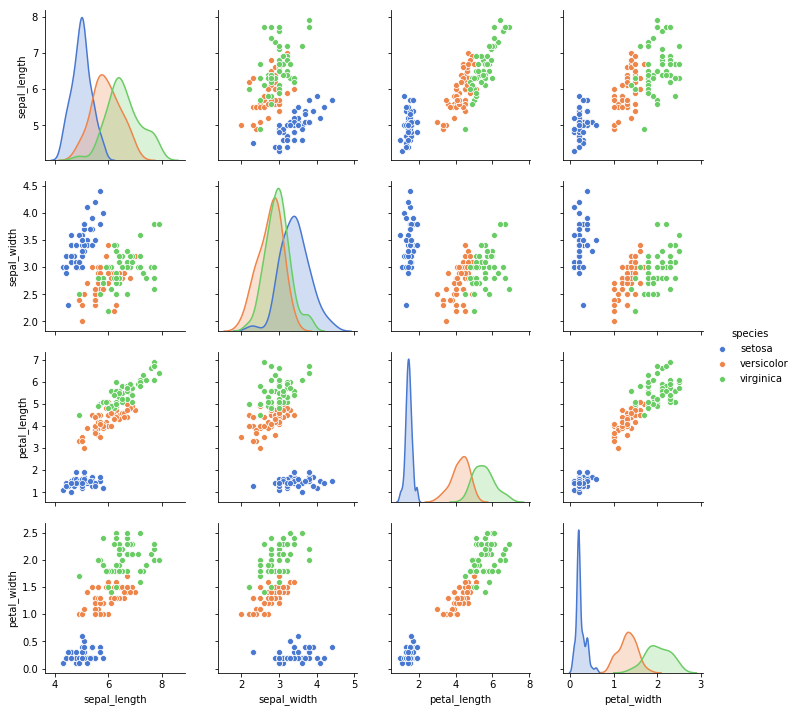

In [0]:
sns.pairplot(iris, hue='species', diag_kind='kde')
plt.savefig('B04958_05_04.png', dpi=300, figsize=(5.5, 5.5))

To do a binary classification, just need to keep the first 100 rows of data. Iris-setosa species is linearly separable from the other two, but the other two are not linearly separable from each other.To keep the species blance Iris-setosa and Iris-versicolor are choosen

In [0]:
iris = iris[:100]

### 2. Numerical Processing
- replace 'Iris-setosa' as 0
- replace 'Iris-versicolor' as 1

In [0]:
iris["species"] = iris["species"].replace(to_replace=['setosa', 'versicolor'], value=[0, 1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


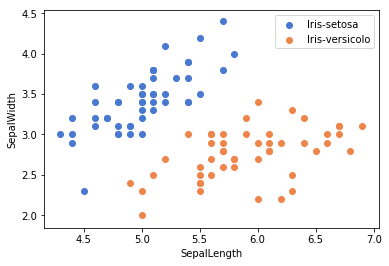

In [0]:
plt.scatter(iris[:50]["sepal_length"], iris[:50]["sepal_width"], label='Iris-setosa')
plt.scatter(iris[51:]["sepal_length"], iris[51:]["sepal_width"], label='Iris-versicolo')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')

In [0]:
X = iris.drop(labels=['species'], axis=1).values
y = iris["species"].values

### 3. Split data
- trainset: 80%
- testset: 20%

In [0]:
# set seed for numpy and tensorflow
# set for reproducible results
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

### 4. Normalized processing

In [0]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
train_X = min_max_normalized(train_X)
test_X = min_max_normalized(test_X)

### 5. Build the model framework

In [0]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 4 features here, A's dimension is (4, 1)
A = tf.Variable(tf.random_normal(shape=[4, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 4])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Declare the model you need to learn
mod = tf.matmul(data, A) + b

# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 30
iter_num = 1500

# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

# Define the goal
goal = opt.minimize(loss)

# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

### 6. Model training

In [0]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.882172 train_acc: 0.462500 test_acc: 0.650000
epoch:  600 loss: 0.682540 train_acc: 0.462500 test_acc: 0.650000
epoch:  900 loss: 0.501576 train_acc: 0.462500 test_acc: 0.650000
epoch: 1200 loss: 0.519480 train_acc: 0.550000 test_acc: 0.800000
epoch: 1500 loss: 0.425639 train_acc: 0.937500 test_acc: 1.000000


### 7. Visualization

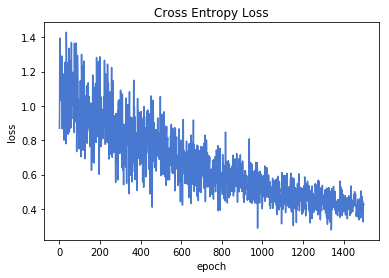

In [0]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

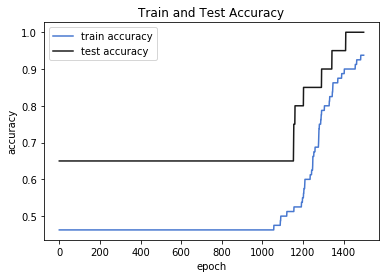

In [0]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

## Example for logistic regression:
let us consider Logistic regression which predict the deaths and survivals of patients. We consider 2000 patients samples measure in metabolic marker. The proportion of deaths of patients in each category is given in below table. and figure plot below shows the proportion of deaths of patients which is described as 'S-shaped' curve. Such that, pattern of proportions cannot lie outside 0 and 1.

                               Table 1 : relatioship between level of metabolic marker and survival


| Metabolic marker level(X) | Number of partients| Number of deaths  | Proportions of deaths |
| --------------------------|:------------------:| -----------------:|----------------------:|
| 0.5 < 1.0                 | 182                |  7                |  0.04                 |
| 1.0 < 1.5                 | 233                |  27               |  0.12                 | 
| 1.5 < 2.0                 | 224                |  44               |  0.20                 | 
| 2.0 < 2.5                 | 236                |  91               |  0.39                 | 
| 2.5 < 3.0                 | 225                |  130              |  0.58                 | 
| 3.0 < 3.5                 | 215                |  168              |  0.78                 | 
| 3.5 < 4.0                 | 221                |  194              |  0.88                 | 
| 4.0 < 4.5                 | 200                |  191              |  0.96                 | 
| >5.0                      | 264                |  260              |  0.98                 | 



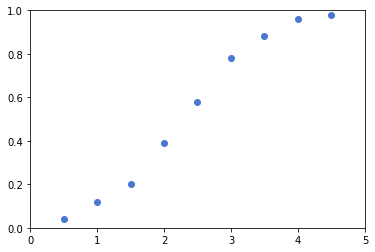

In [2]:
import matplotlib.pyplot as plt
plt.plot([0.5,1,1.5,2,2.5,3,3.5,4,4.5], [0.04,0.12,0.20,0.39,0.58,0.78,0.88,0.96,0.98], 'bo')
plt.axis([0, 5, 0, 1])
plt.show()

#### Logistic regression function with a single quantitative explanatory variable:
logit function is defined as the natural logarithm of the odds of the death.$$\rightarrow logit(p) = \log(\frac{p}{1-p})$$

logistic funtion is used to change the range of proportion from 0-1 to $-\infty $ to $+\infty$

### Binomial distribution:
In probability distribution function if the responce is said to be survivable or deaths then that distribution is said to be a binomial distibution function. Now, the probability of number of deaths in a sample space n is given by $^n C_rp^r(1-p)^{n-r}$  where p is probability function of death and r is number of individuals. The probability of survival is 1-p.

From the above data we take an example of using first row from the table. The probability of 7 deaths occured from 182 patients is given by $ ^{182} C_7 p^7 (1-p)^{175}$ if the probability of deaths assumed to be 0.04 then probability of 7 deaths occured is 0.152. This is calculated using binomial function with parameter p= 0.04 which is known as likelihood. From the below figure we can say that maximum likelihood estimation of to estimate the probability of death is close to 0.04. Mathematically it is shown that maximum likelihood is 7/182.

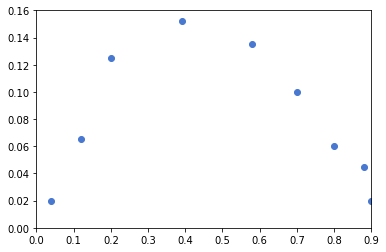

In [4]:
from scipy.stats import binom
fig, ax = plt.subplots(1, 1)

n, p = 182, 0.04
mean, var, skew, kurt = binom.stats(n, p, moments='mvsk')

x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8)
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1)
plt.plot([0.04,0.12,0.20,0.39,0.58,0.7,0.8,0.88,0.9],[0.02,0.065,0.125,0.152,0.135,0.1,0.06,0.045,0.02], 'bo')
plt.axis([0, 0.9, 0, 0.16])
plt.show()


#### Odds:
Logistic model logit(p) = a+bx is equivalent to 
$\frac{p}{1-p} = odds\ of\ death = e^{a+bx}= e^a e^{bx}$

On increase of explanatory variable by one unit from x to x+1, the odds of death changes from $e^a e^b$ to $e^a e^{b(x+1)} = e^a e^b e^{bx}$. The odds ratio there for equal to $e^b$ which has simpler interpretation in categorical explanatory variable with two types. In this case it is justt a odd ratio which compared with other.
Estimates of parameter a and b are usually obtained using statistical package, output of table 1 is summerized in table 2 i.e. if b= 1.690 and $e^bOR = 5.4$ this indicates that odds of death for a patient with marker level of 3 is 5.4 times the marker level of 2.

                                        Table 2: Output from a statistical Package Logistic regression

|        | coeffient | SE  | Wald  | df | P |  OR  |Lower|Upper|
|:------:| ----------|:---:| -----:|---:|:-:|:----:|:---:|:---:|
|Marker  | 1.690     |0.071| 571.07| 1  |0.0|5.421 |4.719|6.227|
|constant| -4.229    |0.191| 489.55| 1  |0.0|

#### predicted probabilities:
This model is used to calculate predicted probability of death for a given metabolic markers 2 and 3. 
    now, predicted probability of death is $ p = \large {\frac {e^{(-4.229+1.699 * 2.0)}}{1+e^{(-4.229+1.699 * 2.0)}}}$ = 0.30 and $ p = \large {\frac {e^{(-4.229+1.699 * 3.0)}}{1+e^{(-4.229+1.699 * 3.0)}}}$ = 0.70
    
The odds of death for the patients are 0.300/(1 - 0.300) = 0.428 and 0.700/(1 - 0.700) = 2.320 giving an odds ratio is 2.320/0.428 = 5.421.

The metabolic marker level which predicted probability equals 0.5 is called the median effective level (EL50). 
by solving the equation
 p = 0.5 = $ \frac{e^{1+bx}}{1+e^{a+bx}}$

gives x = EL50 = a/b 

                          Table 3 : relatioship between level of metabolic marker and predicted probability of death


| Metabolic marker(X) | Number of partients| Number of deaths  | Proportions of deaths | Predicted Probability|Expected deaths| 
| --------------------|:------------------:| -----------------:|----------------------:|:--------------------:|:-------------:|
| 0.5 < 1.0           | 182                |  7                |  0.04                 | 0.04                 |8.2            |
| 1.0 < 1.5           | 233                |  27               |  0.12                 | 0.10                 |24.2           |
| 1.5 < 2.0           | 224                |  44               |  0.20                 | 0.23                 |50.6           |
| 2.0 < 2.5           | 236                |  91               |  0.39                 | 0.41                 |96.0           |
| 2.5 < 3.0           | 225                |  130              |  0.58                 | 0.62                 |140.6          |
| 3.0 < 3.5           | 215                |  168              |  0.78                 | 0.80                 |171.7          |
| 3.5 < 4.0           | 221                |  194              |  0.88                 | 0.90                 |199.9          |
| 4.0 < 4.5           | 200                |  191              |  0.96                 | 0.96                 |191.7          |
| >5.0                | 264                |  260              |  0.98                 | 0.98                 |259.2          |
 

## Multiple logistic regression:
It is similar to multile linear regression. Multiple logistic regression uses more than one independent variables. From logistic model We have following function.
$\Rightarrow \theta = logistic(\alpha + \beta_0 x_0 + \beta_1 x_1) $

In logistic function, when argument is 0 we have $\theta = 0.5$

$\Rightarrow 0.5 = logistic(\alpha + \beta_0 x_0 + \beta_1 x_1)\\
\Rightarrow 0=\alpha + \beta_0 x_0 + \beta_1 x_1 $

Now, we find value of $x_1: \\
\large{=-\frac{\alpha}{\beta_1}+[-\frac{\beta_0}{\beta_1} x_0]}$

This above equation is in form of Mathematical line equation 'c+mx', where first term is intecept and seocound is slope. In two dimensional data space, we can separate it using a line or plane boundary for 3D or higher dimensions respectively. 

### 1. Read the data

In [13]:
# Read the data
uploaded = files.upload()
iris = pd.read_csv(io.BytesIO(uploaded['iris.csv']), sep=',', header=0)
iris = sns.load_dataset("iris")
iris.head()

Saving iris.csv to iris (1).csv


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


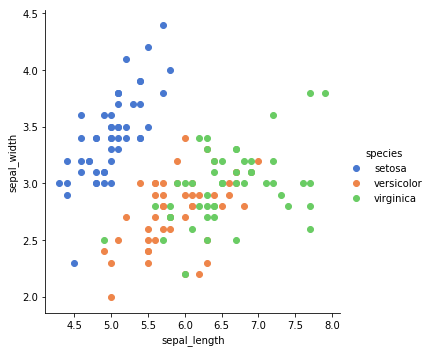

In [14]:
# Visualize the data with sepal_length and sepal_width 
sns.FacetGrid(iris, hue='species', size=5).map(plt.scatter, 'sepal_length', 'sepal_width').add_legend()

### 2. Data Pre-processing

In [15]:
# convert Species name to numerical value
# Iris setosa = 1
# Iris versicolor = 2
# Irsi virginica = 3
iris['species'] = iris['species'].replace(['setosa', 'versicolor','virginica'], [1, 2, 3])
# now let's print some of the data
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [0]:
# X is our features ('sepal_length', 'sepal_width', 'petal_length', 'petal_width')
X = iris.loc[:, ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
# y is our labels
y = iris.loc[:, ['species']]

In [17]:
# declare OneHotEncoder from sklearn
oneHot = OneHotEncoder()
# fit our X to oneHot encoder 
oneHot.fit(X)
# transform
X = oneHot.transform(X).toarray()
# fit our y to oneHot encoder
oneHot.fit(y)
# transform
y = oneHot.transform(y).toarray()

print("Our features X in one-hot format")
print(X)

Our features X in one-hot format
[[0. 1. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [18]:
# Split our data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)

# Print shape of each train and testing
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test", y_test.shape)

Shape of X_train:  (135, 15)
Shape of y_train:  (135, 3)
Shape of X_test:  (15, 15)
Shape of y_test (15, 3)


### 3. Build our model

In [0]:
# hyperparameters
learning_rate = 0.0001
num_epochs = 1500
display_step = 1

# for visualize purpose in tensorboard we use tf.name_scope
with tf.name_scope("Declaring_placeholder"):
    # X is placeholdre for iris features. We will feed data later on
    X = tf.placeholder(tf.float32, [None, 15])
    # y is placeholder for iris labels. We will feed data later on
    y = tf.placeholder(tf.float32, [None, 3])
    
with tf.name_scope("Declaring_variables"):
    # W is our weights. This will update during training time
    W = tf.Variable(tf.zeros([15, 3]))
    # b is our bias. This will also update during training time
    b = tf.Variable(tf.zeros([3]))
    
with tf.name_scope("Declaring_functions"):
    # our prediction function
    y_ = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

In [20]:
with tf.name_scope("calculating_cost"):
    # calculating cost
    cost = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_)
with tf.name_scope("declaring_gradient_descent"):
    # optimizer
    # we use gradient descent for our optimizer 
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

W0727 20:31:12.464782 140255064196992 deprecation.py:323] From <ipython-input-20-2ada64ee3301>:3: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### 4. Train the model

In [21]:
with tf.name_scope("starting_tensorflow_session"):
    with tf.Session() as sess:
        # initialize all variables
        sess.run(tf.global_variables_initializer())
        for epoch in range(num_epochs):
            cost_in_each_epoch = 0
            # let's start training
            _, c = sess.run([optimizer, cost], feed_dict={X: X_train, y: y_train})
            cost_in_each_epoch += c
            # you can uncomment next two lines of code for printing cost when training
            #if (epoch+1) % display_step == 0:
                #print("Epoch: {}".format(epoch + 1), "cost={}".format(cost_in_each_epoch))
        
        print("Optimization Finished!")

        # Test model
        correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
        # Calculate accuracy for 3000 examples
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print("Accuracy:", accuracy.eval({X: X_test, y: y_test}))

Optimization Finished!
Accuracy: 1.0


## Multinomial Regression:
It is model used to predict probability of different possible outcomes of a categorically dependent variable. In this model more than two discrete outcomes are observed. This model is also known as softmax regression model because we use softmax funtion instead of logistic function.

$\Rightarrow \large {softmax(\mu_i)=\frac {e^{\mu_i}}{\sum{e^{\mu_k}}}}$

$y_i \approx Categorical(\theta_i)$  (It can take more than two values)

Example : we have three classes and four input features and we are goind to standerdize the data, which help the sampler to run efficiently.

From the below graphes we can notice difference in shapes of alpha and beta coeffients after using softmax funtion in PYMC3.
From the results it shows 98% of data points are classified correctly. We also noticed that the posterior, the marginal distribution of each parameters are very wide indicated by priors. which does'nt help to make precise decisions, the same problem which we saw in correlated data in linear or logistic regression. In this case, all the wide posterior probability conditions are sum to 1 by using more parameter which we need to fully specify the model.

### 1. Read the data

In [24]:
# Read the data
uploaded = files.upload()
iris = pd.read_csv(io.BytesIO(uploaded['iris.csv']), sep=',', header=0)
iris = sns.load_dataset("iris")
iris.head()

Saving iris.csv to iris (3).csv


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### 2. Data Pre-processing

In [25]:
# One Hot Encode the Species column
iris_one_hot_encoded = pd.get_dummies(iris)
iris_one_hot_encoded.head()

,sepal_length,sepal_width,petal_length,petal_width,species_setosa,species_versicolor,species_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [0]:
# Spit the dataset for training (80%) and testing (20%)
iris_train_data = iris_one_hot_encoded.sample(frac=0.8, random_state=200)
iris_test_data = iris_one_hot_encoded.drop(iris_train_data.index)

In [0]:
iris_train_input_data = iris_train_data.filter(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_train_label_data = iris_train_data.filter(['setosa', 'versicolor', 'virginica'])
iris_test_input_data = iris_test_data.filter(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
iris_test_label_data = iris_test_data.filter(['setosa', 'versicolor', 'virginica'])

In [0]:
x = tf.placeholder(tf.float32,[None, 4])
W = tf.Variable(tf.zeros([4, 3]))
b = tf.Variable(tf.zeros([3]))

### 3. Softmax Regression

y = softmax(W*x + b)

In [0]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None,3])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
sess = tf.InteractiveSession()

tf.global_variables_initializer().run()
for _ in range(1000):
    #Usually send batches to the training step. But since the dataset is small sending all
    sess.run(train_step, feed_dict={x: iris_train_input_data, y_: iris_train_label_data})
    
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print('Accuracy : ', sess.run(accuracy, feed_dict={x: iris_test_input_data, y_: iris_test_label_data}))

## Model comparision and Averaging:
We have discussed what is the problem with different types of models and how to learn value of parameter from the data. In model comparision we are going to compare two or more models used to explain the same data. below are following methods.
### Occam's Razor - simplicity and accuracy:
Occam's Razor is used to choose between two models which explains data or problem equally. It states that if we have different falsifiability criterion explanations for same model, we should choose the one with less complexity. There are many justifications, one of them are pragmatic prespective simpler models, and another one is based one bayesian statistics.
The factors which takes in consideration while comparing models are accuracy ( coefficient of determination $R^2$).
We are going use least mean square approximation for fitting linear models.
#### Overfitting vs underfitting:
From the below data we can see that too many parameters leads to overfitting:

below example shows us misleading of the data fitting to the model. Because, In the model we can improve the accuracy by adding up the parameters. From this we can say that, accuracy measured to fit the model is known as wide-sample accuracy. predictive accuracy of model measured on data not used for fitting the model is known as out-of-sample accuracy.

Too many parameters leads to underfitting:
In this model all beta parameters are set to zero. So, we have reduced the linear model to a guassian of dependent variable. This model is can explained by depedent variable and some guassian noise. hence, we say this model has a underfitting data.

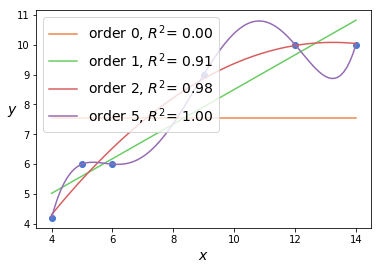

In [0]:
x = np.array([4.,5.,6.,9.,12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2) 
    r2 = ssreg / sstot

    plt.plot(x_n, ffit, label='order {}, $R^2$= {:.2f}'.format(i, r2))

plt.legend(loc=2, fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14, rotation=0)
plt.savefig('B04958_06_01.png', dpi=300, figsize=[5.5, 5.5])
#plt.plot([10, 7], [9, 7], 's')
#plt.savefig('B04958_06_02.png', dpi=300, figsize=[5.5, 5.5])

### Simplicity and Accuracy:
An ideal model should be able to neither overfit or underfit the data. In order to do that we have to tune or model. The purpose of fitting a model is to obtain obtain a compressed representation of data so that is can predict the data.
Balancing of overfitting and underfitting is explained in terms of bias varience trade-off.
High bias is a model with less data. This leads to missing of relavent pattern which is known as underfitting.
High variance is high sensitivity model with lots of information in data. Which leads to addition of noise in data which is known as overfitting.

## Regulizing of Priors:
Prevention of overfitting can be done by using of informative and weakly informative priors. In non-baysien stastics is two major forms of least mean square method known as Ridge regression and lasso regression. According to bayesian point view ridge regression is formed using normal distribution for beta coeffients and lasso regressing is formed using laplace prior. 

from the below graphes a gaussian with a mean zero and a standard deviation comparision is shown.

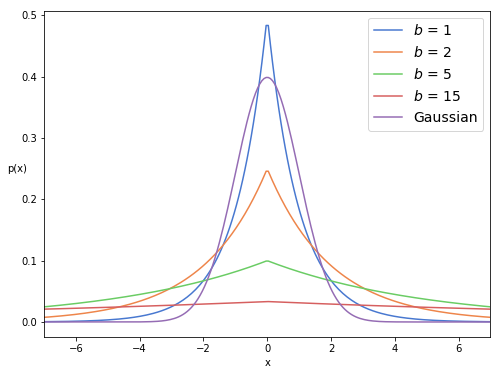

In [0]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 300)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale=df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label='$b$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label='Gaussian')
plt.xlabel('x')
plt.ylabel('p(x)', rotation=0)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);
plt.savefig('B04958_06_03.png', dpi=300, figsize=[5.5, 5.5])

## Information criteria:
Information criteria is defined as collection differenct tools which compare models which show how well they can fit the data while taking complexiting into consideration.
#### The log-likelihood and the deviance :
It is measuring of data which fits the data model to compute the quadratic mean error between data and predictions:

$ \frac{1}{n} \sum (y_i -E(y_i \mid \theta))^2$ where $E(y_i \mid \theta)$ is predicted value for the given estimated parameters. 

here we are going to compute log-likelihood : $$ \log p( y \mid \theta ) $$
for some data this is proportional to the quadratic mean error in simple linear regression case.
from this deviance is  $$ -2\log p( y \mid \theta ) $$ ( where is $\theta$ is estimated from posterior)

##### Akaike information criterion:
This is widely used information criterion for non-bayesians which is : $ AIC =-2 \log p( y \mid \hat \theta_{mle} ) + 2 p_{AIC} $        ( here, $P_AIC$ is number of parameters and $\hat \theta_{mle}$ is maximum likelihood estimation of $\theta$)


Alternatively, we can represent the previous formula  as :  $ AIC =-2 \left(\log p( y \mid \hat \theta_{mle} ) -  p_{AIC} \right) $ 

##### Deviation information criterion :
Deviation information criterion(DIC) find a way to include AIC information from posterior  and also estimate  the number of parameters from the model and data. DIC =  $ -2 \times \log p( y \mid \hat \theta_{post} ) + 2 p_{dic} $ 

we can see the DIC and AIC are analogous. Now we are computing deviance from $\hat \theta _{post}$. $P_{dic}$ is $ \hat D(\theta) - D ( \hat \theta)$
We can say that DIC is more bayesian version of AIC 


### Bayes factors:
Most common way to compare models in bayesian analysis in bayes factor.
we know that bayes factor is : $ p(\theta \mid y) =\large{ \frac { p(y \mid \theta) p(\theta)}{p(y)}}$
where Y is data and $ \theta $ is parameters .
Now we can re-write the equation as - $ p(\theta \mid y, M) =\Large{ \frac { p(y \mid \theta, M) p(\theta \mid M)}{p(y \mid M)}}$    ( $p(y \mid M)$ is mariginal likelihood).

 we can write the evidence as $ p( y, M) ={ \int {p(y \mid \theta, M) p(\theta \mid M)}d\theta_m}$ 
 
 to compute evidence we need to marginalize over all the possible values of $p(\theta \mid M)$
 now we take the ratios of evidence  BF = $ \Large {\frac { p(y \mid M_o)} {p( y \mid M_1)}} $
 
 if BF > 1 then model 0  explains data better than model 1.

# References:


[1] Using Tensorflow to implement Logistic Regression model | Kaggle.[Online].Available: https://www.kaggle.com/autuanliuyc/logistic-regression-with-tensorflow
<br>
[2] Logistic regression in Tensorflow for beginner | Kaggle.[Online].Available: https://www.kaggle.com/niyamatalmass/logistic-regression-in-tensorflow-for-beginner
<br>
[3] Iris TensorFlow Basic Softmax Regression | Kaggle.[Online].Available: 
https://www.kaggle.com/vijayshinva/iris-tensorflow-basic-softmax-regression